# Spotify web API exploration using the spotipy package

Via Spotify for developers, you'll first need to create a Client ID and a Client SECRET. Mine are in the file SECRET.py.

## Connect 

In [9]:
# imports
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from SECRET import SPOTIFY_CLIENT_ID, SPOTIFY_CLIENT_SECRET, GENIUS_CLIENT_ID, GENIUS_CLIENT_SECRET, GENIUS_ACCESS_TOKEN
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime


In [10]:
cid = SPOTIFY_CLIENT_ID
secret = SPOTIFY_CLIENT_SECRET
client_credentials_manager = SpotifyClientCredentials(
    client_id=cid, client_secret=secret
)
spotify = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

## Get data

Spotify works with unique identifiers for artists, tracks, playlists etc. 

The file below is a file I retrieved from Kaggle that holds about 80 000 artist uids.

In [3]:
artists_identifiers = pd.read_csv("artist-uris.csv", names=['artist', 'uid'])
artists_identifiers = artists_identifiers.dropna()
artists_identifiers.sample(2)

,artist,uid
26026,Hayley Blake,spotify:artist:323Zm4tNhVSh8X5zEMRpDR
55764,Raphael Gualazzi,spotify:artist:6hu9cUsJDFg2kUkAAjOepA


In [4]:
artists_identifiers.loc[artists_identifiers.artist == "Johnny Cash"]

,artist,uid
33572,Johnny Cash,spotify:artist:6kACVPfCOnqzgfEF5ryl0x


In [5]:
cash_uri = "spotify:artist:6kACVPfCOnqzgfEF5ryl0x"

### Get top tracks for artist

In [6]:
results = spotify.artist_top_tracks(cash_uri)

for track in results["tracks"][:5]:
    print(f"track     : {track['name']}")
    print(f"uri       : {track['uri']}")
    print(f"audio     : {track['preview_url']}")
    print(f"popularity: {track['popularity']}")
    print(f"cover art : {track['album']['images'][0]['url']}")
    print("------------")

track     : Hurt
uri       : spotify:track:28cnXtME493VX9NOw9cIUh
audio     : None
popularity: 74
cover art : https://i.scdn.co/image/ab67616d0000b2736f4f62da3d811b6501a69ffa
------------
track     : Ring of Fire
uri       : spotify:track:6YffUZJ2R06kyxyK6onezL
audio     : https://p.scdn.co/mp3-preview/e3bbba328a3227e0d1095f804cd73a634de8cd04?cid=206e5e7f722342d8b85b35104d6b367a
popularity: 70
cover art : https://i.scdn.co/image/ab67616d0000b273dfe4bfe695c4192e547e72c7
------------
track     : Highwayman
uri       : spotify:track:7jWbXvrgdbkajU8L28ahn5
audio     : https://p.scdn.co/mp3-preview/fad7aafefc453944b444407dd7f4eff196ed23da?cid=206e5e7f722342d8b85b35104d6b367a
popularity: 69
cover art : https://i.scdn.co/image/ab67616d0000b2735b819ab33345f5e4c7092233
------------
track     : Folsom Prison Blues
uri       : spotify:track:1Vw5YUBbtlUmkhEnee55Zo
audio     : None
popularity: 50
cover art : https://i.scdn.co/image/ab67616d0000b2730a0738b2cae1b731a9e273a7
------------
track     : I

A note on popularity: 

The value will be between 0 and 100, with 100 being the most popular.
The popularity of a track is a value between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are.
Generally speaking, songs that are being played a lot now will have a higher popularity than songs that were played a lot in the past. Duplicate tracks (e.g. the same track from a single and an album) are rated independently. Artist and album popularity is derived mathematically from track popularity. Note that the popularity value may lag actual popularity by a few days: the value is not updated in real time.

In [7]:
cash_tracks = {track['uri']:{'name':track['name'],'popularity':track['popularity']} for track in results['tracks'][:2]}

### Get audio features

to find out what the features mean, refer to: https://developer.spotify.com/documentation/web-api/reference/#category-tracks and search for <b>TuneableTrackObject</b>


In [8]:
# compare hurt and ring of fire
cash_audio_features = pd.DataFrame(spotify.audio_features(cash_tracks.keys()))

In [9]:
cash_audio_features["name"] = [track["name"] for track in cash_tracks.values()]
cash_audio_features["popularity"] = [
    track["popularity"] for track in cash_tracks.values()
]
cash_audio_features = cash_audio_features.set_index(
    cash_audio_features["name"]
)  # set track name as index

In [10]:
cash_audio_features

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,name,popularity
name,,,,,,,,,,,,,,,,,,,,
Hurt,0.534,0.392,9,-7.636,0,0.0267,0.649,0.000227,0.0948,0.163,90.379,audio_features,28cnXtME493VX9NOw9cIUh,spotify:track:28cnXtME493VX9NOw9cIUh,https://api.spotify.com/v1/tracks/28cnXtME493V...,https://api.spotify.com/v1/audio-analysis/28cn...,216533,4,Hurt,74
Ring of Fire,0.659,0.585,7,-8.189,1,0.0288,0.623,0.000213,0.3480,0.784,104.111,audio_features,6YffUZJ2R06kyxyK6onezL,spotify:track:6YffUZJ2R06kyxyK6onezL,https://api.spotify.com/v1/tracks/6YffUZJ2R06k...,https://api.spotify.com/v1/audio-analysis/6Yff...,158427,4,Ring of Fire,70


Let's visualize this

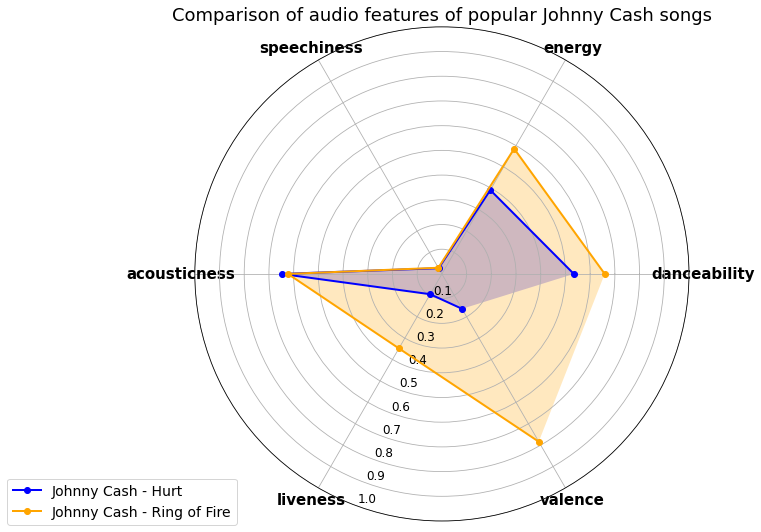

In [11]:
visualize_features = [
    "danceability",
    "energy",
    "speechiness",
    "acousticness",
    "liveness",
    "valence",
]

angles = np.linspace(0, 2 * np.pi, len(visualize_features), endpoint=False)
fig = plt.figure(figsize=(20, 20))


Hurt_features = cash_audio_features[visualize_features].loc["Hurt"].values
Ring_of_Fire_features = (
    cash_audio_features[visualize_features].loc["Ring of Fire"].values
)

ax = fig.add_subplot(221, polar=True)
ax.plot(
    angles, Hurt_features, "o-", linewidth=2, label="Johnny Cash - Hurt", color="blue"
)
ax.fill(angles, Hurt_features, alpha=0.25, facecolor="blue")
ax.set_thetagrids(
    angles * 180 / np.pi, visualize_features, fontsize=15, fontweight="bold"
)

ax.set_rlabel_position(250)
plt.yticks(
    [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    ["0.1", "0.2", "0.3", "0.4", "0.5", "0.6", "0.7", "0.8", "0.9", "1.0"],
    size=12,
)
plt.ylim(0, 1)

ax.plot(
    angles,
    Ring_of_Fire_features,
    "o-",
    linewidth=2,
    label="Johnny Cash - Ring of Fire",
    color="orange",
)
ax.fill(angles, Ring_of_Fire_features, alpha=0.25, facecolor="orange")
ax.set_title("Comparison of audio features of popular Johnny Cash songs", fontsize=18)
ax.grid(True)

plt.legend(loc="best", bbox_to_anchor=(0.1, 0.1), fontsize=14)

In [12]:
# spotify.audio_analysis('spotify:track:28cnXtME493VX9NOw9cIUh') # extensive analysis of different chunks in single track

### Get song lyrics using the Genius API

In [13]:
import lyricsgenius
genius = lyricsgenius.Genius(GENIUS_ACCESS_TOKEN)

In [22]:
song = genius.search_song("Hurt", "Johnny Cash")
song.lyrics

Searching for "Hurt" by Johnny Cash...
Done.


"[Produced by Rick Rubin]\n\n[Verse 1]\nI hurt myself today\nTo see if I still feel\nI focus on the pain\nThe only thing that's real\nThe needle tears a hole\nThe old familiar sting\nTry to kill it all away\nBut I remember everything\n\n[Chorus]\nWhat have I become\nMy sweetest friend?\nEveryone I know\nGoes away in the end\nAnd you could have it all\nMy empire of dirt\nI will let you down\nI will make you hurt\n\n[Verse 2]\nI wear this crown of thorns\nUpon my liar's chair\nFull of broken thoughts\nI cannot repair\nBeneath the stains of time\nThe feelings disappear\nYou are someone else\nI am still right here\n[Chorus]\nWhat have I become\nMy sweetest friend?\nEveryone I know\nGoes away in the end\nAnd you could have it all\nMy empire of dirt\nI will let you down\nI will make you hurt\n\n[Outro]\nIf I could start again\nA million miles away\nI would keep myself\nI would find a way136EmbedShare URLCopyEmbedCopy"

In [20]:
song2 = genius.search_song("Ring of Fire", "Johnny Cash")


Searching for "Ring of Fire" by Johnny Cash...
Done.


In [21]:
song2.lyrics

'[Verse 1]\nLove is a burning thing\nAnd it makes a fiery ring\nBound by wild desire\nI fell in to a ring of fire\n\n[Chorus]\nI fell into a burning ring of fire\nI went down, down, down\nAnd the flames went higher\nAnd it burns, burns, burns\nThe ring of fire\nThe ring of fire\nI fell into a burning ring of fire\nI went down, down, down\nAnd the flames went higher\nAnd it burns, burns, burns\nThe ring of fire\nThe ring of fire\n\n[Verse 2]\nThe taste of love is sweet\nWhen hearts like ours meet\nI fell for you like a child\nOh, but the fire went wild\n[Chorus]\nI fell in to a burning ring of fire\nI went down, down, down\nAnd the flames went higher\nAnd it burns, burns, burns\nThe ring of fire\nThe ring of fire\nI fell into a burning ring of fire\nI went down, down, down\nAnd the flames went higher\nAnd it burns, burns, burns\nThe ring of fire\nThe ring of fire\n\n[Outro]\nAnd it burns, burns, burns\nThe ring of fire\nThe ring of fire\nThe ring of fire\nThe ring of fire\nThe ring of f

In [17]:
vars(song)[]

{'id': 85072,
 '_body': {'_type': 'song',
  'annotation_count': 15,
  'api_path': '/songs/85072',
  'full_title': 'Hurt by\xa0Johnny\xa0Cash',
  'header_image_thumbnail_url': 'https://images.genius.com/1741fd60e38db6d35731f03d95fa6458.300x300x1.jpg',
  'header_image_url': 'https://images.genius.com/1741fd60e38db6d35731f03d95fa6458.1000x1000x1.jpg',
  'id': 85072,
  'instrumental': False,
  'lyrics_owner_id': 5,
  'lyrics_state': 'complete',
  'lyrics_updated_at': 1557861818,
  'path': '/Johnny-cash-hurt-lyrics',
  'pyongs_count': 136,
  'song_art_image_thumbnail_url': 'https://images.genius.com/3efa8083445d42bdc57e376286260abd.300x300x1.jpg',
  'song_art_image_url': 'https://images.genius.com/3efa8083445d42bdc57e376286260abd.500x500x1.jpg',
  'stats': {'unreviewed_annotations': 0, 'hot': False, 'pageviews': 861879},
  'title': 'Hurt',
  'title_with_featured': 'Hurt',
  'updated_by_human_at': 1616211855,
  'url': 'https://genius.com/Johnny-cash-hurt-lyrics',
  'song_art_primary_color': 

### Get a popular playlist
The top 50 global: https://open.spotify.com/playlist/37i9dQZEVXbMDoHDwVN2tF?si=2afa3c8931b84b60.

This playlist is updated daily

In [137]:
playlist_url = (
    "https://open.spotify.com/playlist/37i9dQZEVXbMDoHDwVN2tF?si=2afa3c8931b84b60"
)

# query tracks of playlist
track_dicts = spotify.playlist(playlist_url)["tracks"]["items"]

# initialize dataframe
playlist_df = pd.DataFrame(
    columns=[
        "date_of_scrape",
        "artist",
        "name",
        "track_id",
        "position",
        "popularity",
        "date_added",
        "preview_url",
        "spotify_url",
    ]
)


for index, track_dict in enumerate(track_dicts):

    date_added = track_dict["added_at"].split("T")[0]
    position = index + 1

    # all other interesting variables are inside the 'track' dict
    track_dict = track_dict["track"]

    track_id = track_dict["id"]
    track_artist = " ft. ".join(
        [artist_dict["name"] for artist_dict in track_dict["artists"]]
    )
    track_name = track_dict["name"]
    popularity = track_dict["popularity"]
    preview_url = track_dict["preview_url"]
    spotify_url = track_dict["external_urls"]["spotify"]

    row_dict = {
        "track_id": [track_id],
        "artist": [track_artist],
        "name": [track_name],
        "position": [position],
        "popularity": [popularity],
        "date_added": [date_added],
        "preview_url": [preview_url],
        "spotify_url": [spotify_url],
    }

    row_df = pd.DataFrame(row_dict)

    playlist_df = playlist_df.append(row_df)

playlist_df["date_of_scrape"] = datetime.today().date()

In [139]:
playlist_df.head()

,date_of_scrape,artist,name,track_id,position,popularity,date_added,preview_url,spotify_url
0,2021-08-18,The Kid LAROI ft. Justin Bieber,STAY (with Justin Bieber),5PjdY0CKGZdEuoNab3yDmX,1,89,2021-08-17,https://p.scdn.co/mp3-preview/dd4d8d66b97b6edc...,https://open.spotify.com/track/5PjdY0CKGZdEuoN...
0,2021-08-18,Lil Nas X ft. Jack Harlow,INDUSTRY BABY (feat. Jack Harlow),27NovPIUIRrOZoCHxABJwK,2,97,2021-08-17,https://p.scdn.co/mp3-preview/406f8a854c3a2a3a...,https://open.spotify.com/track/27NovPIUIRrOZoC...
0,2021-08-18,Måneskin,Beggin',3Wrjm47oTz2sjIgck11l5e,3,100,2021-08-17,https://p.scdn.co/mp3-preview/c956a56a9a3103ad...,https://open.spotify.com/track/3Wrjm47oTz2sjIg...
0,2021-08-18,Ed Sheeran,Bad Habits,6PQ88X9TkUIAUIZJHW2upE,4,98,2021-08-17,https://p.scdn.co/mp3-preview/0e537207ad0fff8c...,https://open.spotify.com/track/6PQ88X9TkUIAUIZ...
0,2021-08-18,Olivia Rodrigo,good 4 u,4ZtFanR9U6ndgddUvNcjcG,5,99,2021-08-17,None,https://open.spotify.com/track/4ZtFanR9U6ndgdd...


### Get new releases

Get a list of new album releases featured in Spotify. 

The parameter 'offset' can be used to define the index of what you want to have returned, so, if you query new releases multiple times, make sure to increment offset with the limit. 

In [162]:
new_releases_album_uris = [album['uri'] for album in spotify.new_releases(limit=50)['albums']['items']] # maximum limit 

# initialize new_releases_df
new_releases_df = pd.DataFrame(
    columns=[
        "date_of_scrape",
        "artist",
        "name",
        "track_id",
        "popularity",
        "preview_url",
        "spotify_url",
        "danceability",
        "energy",
        "key",
        "loudness",
        "mode",
        "speechiness",
        "acousticness",
        "instrumentalness",
        "liveness",
        "valence",
        "tempo",
        "duration_ms",
    ]
)

audio_features = [
    "danceability",
    "energy",
    "key",
    "loudness",
    "mode",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
    "duration_ms",
]

for album_uri in new_releases_album_uris:
    album_tracks = spotify.album_tracks(album_uri)["items"]

    for track in album_tracks:
        track_id = track["id"]
        track_artist = " ft. ".join(
            [artist_dict["name"] for artist_dict in track["artists"]]
        )
        track_name = track["name"]
        popularity = spotify.track(track_id)["popularity"]
        preview_url = track["preview_url"]
        spotify_url = track["external_urls"]["spotify"]

        row_dict = {
            "track_id": [track_id],
            "artist": [track_artist],
            "name": [track_name],
            "popularity": [popularity],
            "preview_url": [preview_url],
            "spotify_url": [spotify_url],
        }
        
        track_features = pd.DataFrame(spotify.audio_features(track["id"]))[
            audio_features
        ]
        
        row_df = pd.DataFrame(row_dict)
        
        new_releases_df = new_releases_df.append(pd.concat([row_df, track_features], axis=1))

new_releases_df["date_of_scrape"] = datetime.today().date()

In [224]:
new_releases_df

,date_of_scrape,artist,name,track_id,popularity,preview_url,spotify_url,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,2021-08-18,Lizzo ft. Cardi B,Rumors (feat. Cardi B),6KgtcmCF9Ky68XC7ezxl3s,81,https://p.scdn.co/mp3-preview/252a7be97bc9172a...,https://open.spotify.com/track/6KgtcmCF9Ky68XC...,0.827,0.731,4,-5.524,0,0.0880,0.1300,0,0.4180,0.6070,118.992,172833
0,2021-08-18,Tiësto ft. KAROL G,Don't Be Shy,0bI7K9Becu2dtXK1Q3cZNB,75,https://p.scdn.co/mp3-preview/54889f56ba255f24...,https://open.spotify.com/track/0bI7K9Becu2dtXK...,0.770,0.787,11,-3.748,0,0.0583,0.1980,0,0.2620,0.5130,119.986,140500
0,2021-08-18,Elton John ft. Dua Lipa ft. PNAU,Cold Heart - PNAU Remix,6zSpb8dQRaw0M1dK8PBwQz,75,None,https://open.spotify.com/track/6zSpb8dQRaw0M1d...,0.796,0.798,1,-6.312,1,0.0317,0.0340,0.000042,0.0952,0.9420,116.032,202735
0,2021-08-18,PinkPantheress,Just for me,6OTKVgVpVaVjhRLYizPJKA,74,https://p.scdn.co/mp3-preview/c9f694a4a34dfcc1...,https://open.spotify.com/track/6OTKVgVpVaVjhRL...,0.778,0.628,0,-7.844,1,0.0618,0.7050,0.00193,0.2990,0.6980,133.048,115801
0,2021-08-18,The Killers,West Hills,5hiZJE6Fg14Wao6EJ0KUC8,60,None,https://open.spotify.com/track/5hiZJE6Fg14Wao6...,0.318,0.670,0,-6.306,0,0.0528,0.4750,0.00395,0.5770,0.1900,169.893,342013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2021-08-18,Jennifer Hudson,I Say A Little Prayer,5mwGeEwTdPZ0uMDab8YJkJ,33,https://p.scdn.co/mp3-preview/52230cc38f5d5db1...,https://open.spotify.com/track/5mwGeEwTdPZ0uMD...,0.642,0.700,9,-6.034,1,0.0306,0.2550,0.000409,0.0611,0.9250,132.982,221199
0,2021-08-18,Jennifer Hudson,Precious Memories,2AV8f5QE4wYWBiNWJovm7H,29,https://p.scdn.co/mp3-preview/31b26af51eea40e4...,https://open.spotify.com/track/2AV8f5QE4wYWBiN...,0.283,0.336,3,-12.091,1,0.0322,0.8750,0,0.3000,0.2720,96.437,117528
0,2021-08-18,Jennifer Hudson,Amazing Grace,4ueHG37Gma2HraxPyX15Yb,31,https://p.scdn.co/mp3-preview/c073bbadec9b6889...,https://open.spotify.com/track/4ueHG37Gma2Hrax...,0.213,0.240,8,-12.089,1,0.0319,0.8450,0.000267,0.0950,0.1570,98.780,303000
0,2021-08-18,Jennifer Hudson,Here I Am (Singing My Way Home),6wLJiRkrSbqPzbNnrKSYNX,29,https://p.scdn.co/mp3-preview/f2a3ff9cfdf0324c...,https://open.spotify.com/track/6wLJiRkrSbqPzbN...,0.368,0.214,8,-12.987,1,0.0353,0.0624,0.00218,0.1040,0.0773,74.475,314290


# Others

In [17]:
# artist popularity
spotify.artist("https://open.spotify.com/artist/6mS5GeFyhea6w9OKo8PO3p?si=tZnuKuf_QjSLcDZosNxQhQ&dl_branch=1")

{'external_urls': {'spotify': 'https://open.spotify.com/artist/6mS5GeFyhea6w9OKo8PO3p'},
 'followers': {'href': None, 'total': 16271},
 'genres': ['piratenmuziek'],
 'href': 'https://api.spotify.com/v1/artists/6mS5GeFyhea6w9OKo8PO3p',
 'id': '6mS5GeFyhea6w9OKo8PO3p',
 'images': [{'height': 640,
   'url': 'https://i.scdn.co/image/ab6761610000e5eb1ef4c49ccd5f2092e18a5d3a',
   'width': 640},
  {'height': 320,
   'url': 'https://i.scdn.co/image/ab676161000051741ef4c49ccd5f2092e18a5d3a',
   'width': 320},
  {'height': 160,
   'url': 'https://i.scdn.co/image/ab6761610000f1781ef4c49ccd5f2092e18a5d3a',
   'width': 160}],
 'name': 'Goldband',
 'popularity': 55,
 'type': 'artist',
 'uri': 'spotify:artist:6mS5GeFyhea6w9OKo8PO3p'}

In [16]:
# release date of a track
spotify.track("6KgtcmCF9Ky68XC7ezxl3s")["album"]["release_date"]

'2021-08-13'

# Manage playlist
The resulting predicted playlist can also be created and managed via spotipy! See: https://spotipy.readthedocs.io/en/2.18.0/.  
For instance with playlist_add_items, playlist_change_details, playlist_remove_all_occurences_of_itmes etc.